### 导入程序包

In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from pytorchtools import EarlyStopping
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, random_split, DataLoader
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import preprocessing
from scipy.stats import norm, skew
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import math
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import datetime

### 导入数据, 特征选择, 数据处理

In [2]:
train = pd.read_csv('zhengqi_train.txt', sep='\t')
test = pd.read_csv('zhengqi_test.txt', sep='\t')


all_data = pd.concat([train, test])
y_train = train['target']
print(y_train.shape)
all_data.drop(columns=['target'],inplace=True)
print(all_data.shape)
all_data = all_data.drop(["V5", "V9", "V11", "V17", "V22", "V28"], axis=1)
print(all_data.shape)

scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
all_data = pd.DataFrame(scaler.fit_transform(all_data), columns=all_data.columns)
print("Scale done.")


all_data['V0'] = all_data['V0'].apply(lambda x:math.exp(x))
all_data['V1'] = all_data['V1'].apply(lambda x:math.exp(x))
#all_data['V4'] = all_data['V4'].apply(lambda x:math.exp(x))
all_data['V6'] = all_data['V6'].apply(lambda x:math.exp(x))
all_data['V7'] = all_data['V7'].apply(lambda x:math.exp(x))
all_data['V8'] = all_data['V8'].apply(lambda x:math.exp(x))
#all_data['V12'] = all_data['V12'].apply(lambda x:math.exp(x))
#all_data['V16'] = all_data['V16'].apply(lambda x:math.exp(x))
#all_data['V26'] = all_data['V26'].apply(lambda x:math.exp(x))
#all_data['V27'] = all_data['V27'].apply(lambda x:math.exp(x))
all_data["V30"] = np.log1p(all_data["V30"])
#all_data["V31"] = np.log1p(all_data["V31"])
#all_data["V32"] = np.log1p(all_data["V32"])
#y_train = np.exp(y_train)


scaled = pd.DataFrame(preprocessing.scale(all_data), columns = all_data.columns)
X_train = scaled.loc[0:len(train)-1]
X_test = scaled.loc[len(train):]
print("y skew:", skew(y_train))
print("Skewness done.")
print("偏态后的shape", X_train.shape, X_test.shape, y_train.shape)


#方差
threshold = 0.85
vt = VarianceThreshold().fit(X_train)
# Find feature names
feat_var_threshold = X_train.columns[vt.variances_ > threshold * (1-threshold)]
X_train = X_train[feat_var_threshold]
X_test = X_test[feat_var_threshold]
all_data = pd.concat([X_train, X_test])
print("方差后的shape", all_data.shape)
#单变量
X_scored = SelectKBest(score_func=f_regression, k='all').fit(X_train, y_train)
feature_scoring = pd.DataFrame({
        'feature': X_train.columns,
        'score': X_scored.scores_
    })
head_feature_num = 18
feat_scored_headnum = feature_scoring.sort_values('score', ascending=False).head(head_feature_num)['feature']
X_train_head = X_train[X_train.columns[X_train.columns.isin(feat_scored_headnum)]]
X_scaled = pd.DataFrame(preprocessing.scale(X_train),columns = X_train.columns)
X_test_head = X_test[X_test.columns[X_test.columns.isin(feat_scored_headnum)]]
print("单变量选择后的shape")
print(X_train_head.shape)
print(y_train.shape)
print(X_test_head.shape)

(2888,)
(4813, 38)
(4813, 32)
Scale done.
y skew: -0.8975628185495536
Skewness done.
偏态后的shape (2888, 32) (1925, 32) (2888,)
方差后的shape (4813, 31)
单变量选择后的shape
(2888, 18)
(2888,)
(1925, 18)


### 构建数据管道

In [3]:
train_numpy = np.array(X_train_head)
test_numpy = np.array(X_test_head)

X_numpy = train_numpy
Y_numpy = np.array(y_train)

X_train = torch.tensor(train_numpy, dtype = torch.float32)
Y_train = torch.tensor(np.array(y_train), dtype = torch.float32)
Y_train = Y_train.reshape(-1,1)
X_test = torch.tensor(test_numpy, dtype = torch.float32)
print('输入特征个数:',X_train.shape[1])
print('输入特征个数:',X_test.shape[1])

输入特征个数: 18
输入特征个数: 18


### 定义模型与损失函数

In [4]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.layer1 = nn.Sequential()
        self.layer1.add_module('linear1', nn.Linear(18,100))
        self.layer1.add_module('dropout1',nn.Dropout(p=0.5))
        #self.layer1.add_module('batchnorm1',nn.BatchNorm1d(100))
        self.layer1.add_module('activate1',nn.ReLU())
        
        self.layer2 = nn.Sequential()
        self.layer2.add_module('linear2',nn.Linear(100,50))
        #self.layer2.add_module('dropout2',nn.Dropout(p=0.5))
        #self.layer2.add_module('batchnorm2',nn.BatchNorm1d(50))
        self.layer2.add_module('activate2',nn.ReLU())
        
        self.layer3 = nn.Sequential()
        self.layer3.add_module('linear3',nn.Linear(50,10))
        #self.layer3.add_module('batchnorm3',nn.BatchNorm1d(10))
        self.layer3.add_module('activate3',nn.ReLU())
        
        self.layer4 = nn.Sequential()
        self.layer4.add_module('linear4',nn.Linear(10,1))
        #self.layer4.add_module('batchnorm4',nn.BatchNorm1d(10))
        #self.layer4.add_module('activate4',nn.Sigmoid())
        


    # 正向传播
    def forward(self,x):
        a1 = self.layer1(x)
        a2 = self.layer2(a1)
        a3 = self.layer3(a2)
        y = self.layer4(a3)
        return y

print(DNNModel())

loss_func = nn.MSELoss()

DNNModel(
  (layer1): Sequential(
    (linear1): Linear(in_features=18, out_features=100, bias=True)
    (dropout1): Dropout(p=0.5, inplace=False)
    (activate1): ReLU()
  )
  (layer2): Sequential(
    (linear2): Linear(in_features=100, out_features=50, bias=True)
    (activate2): ReLU()
  )
  (layer3): Sequential(
    (linear3): Linear(in_features=50, out_features=10, bias=True)
    (activate3): ReLU()
  )
  (layer4): Sequential(
    (linear4): Linear(in_features=10, out_features=1, bias=True)
  )
)


### 定义模型训练函数

In [5]:
def train_model(net, d_train, d_dev, epochs = 300, learning_rate = 0.001, weight_decay = 0.01, patience = 20,log_step_freq=20):
    # Adam 优化算法
    optimizer = torch.optim.Adam(net.parameters(),lr = learning_rate, weight_decay = weight_decay)
    
    # 设置学习速率衰减
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma = 0.9)
    
    # 创建日志
    dfhistory = pd.DataFrame(columns = ["epoch","loss","val_loss"]) 
    
    # 0, 开始学习-------------------------------------------------
    print("Start Training...")
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("=========="*8 + "%s"%nowtime)
    
    # 设置 early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    mini_val_loss = 100
    mini_train_loss = 100
    
    for epoch in range(epochs+1):
        # 1，训练循环-------------------------------------------------
        loss_sum = 0.0
        step = 1
        net.train()
        for step, (x,y) in enumerate(d_train, 1):
            optimizer.zero_grad()
            y_hat = net(x)
            loss = loss_func(y_hat,y)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
            # 打印batch日志
            #if step%log_step_freq == 0 and epoch%log_step_freq == 0:   
            #    print(("[step = %d] loss: %.3f, ") % (step, loss_sum/step))
        scheduler.step()
        mini_train_loss = min(loss_sum/step, mini_train_loss)
    
        # 2，测试循环-------------------------------------------------
        val_loss_sum = 0.0
        val_step = 1
        with torch.no_grad():
            net.eval()
            for val_step, (x,y) in enumerate(d_dev, 1):
                y_hat = net(x)
                val_loss = loss_func(y_hat,y)
                val_loss_sum += val_loss.item()
        
        # 3，记录日志-------------------------------------------------
        info = (epoch, loss_sum/step, val_loss_sum/val_step)
        dfhistory.loc[epoch] = info
        mini_val_loss = min(val_loss_sum/val_step, mini_val_loss)
        
        #若开发集上的损失函数连续 patience 次不减, 则结束模型训练
        early_stopping(val_loss_sum/val_step, net)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        #if epoch%log_step_freq == 0:
            # 打印epoch日志
         #   print(("\nEPOCH = %d, loss = %.3f, val_loss = %.3f") %info)
         #   nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
         #   print("\n"+"=========="*8 + "%s"%nowtime)
    
    print('Finished Training...')
    return dfhistory, mini_train_loss, mini_val_loss, epoch

#dfhistory.to_csv('(50_20_10)-(3,2)_18_earlydrop_5fold.csv', sep=' ', header=False, index=False)
#dfhistory[['loss','val_loss']].plot()

### 定义 K-折交叉训练函数

In [6]:
def K_Fold_train(X,Y, k=5, epochs = 300, learning_rate = 0.001, weight_decay = 0.01, patience = 20,log_step_freq=20):
    '''
    对训练集进行 k-折交叉训练, 得到 k 个神经网络, 返回训练日志, 神经网络, 以及训练次数
    '''
    # k-折的总损失
    train_loss_sum, val_loss_sum = 0, 0
    # 使用 sklearn 中的 KFlod 
    skf = KFold(n_splits=k, shuffle=True)
    # 记录每一折的学习日志，训练集损失，开发集损失，训练次数，神经网络
    history = {}
    train_loss = {}
    dev_loss = {}
    epoch = {}
    Net = {}
    # k-折交叉训练
    for fold, (train_index, test_index) in enumerate(skf.split(X,Y)):
        # 封装第 k 折数据管道
        x_train, x_dev = X[train_index], X[test_index]
        y_train, y_dev = Y[train_index], Y[test_index]
        #print(x_train.shape)
        #print(x_dev.shape)
        data_train = TensorDataset(x_train,y_train)
        data_dev = TensorDataset(x_dev,y_dev)
        d_train = DataLoader(data_train, batch_size = 32, shuffle = True,drop_last = False)
        d_dev = DataLoader(data_dev, batch_size = 32, shuffle = True,drop_last = False)
        # 实例化模型
        Net['fold'+str(fold)] = DNNModel() 
        # 对第 k 折数据进行训练
        history['fold'+str(fold)], train_loss['fold'+str(fold)], \
        dev_loss['fold'+str(fold)], epoch['fold'+str(fold)] \
        = train_model(Net['fold'+str(fold)],d_train, d_dev, epochs, learning_rate, weight_decay, patience, log_step_freq)
        print(history['fold'+str(fold)])
        # 叠加第 k 折的损失
        train_loss_sum += train_loss['fold'+str(fold)]
        val_loss_sum += dev_loss['fold'+str(fold)]
    
    # 打印训练结果
    for fold in range(k):
        print('='*10,'第',fold+1,'折','='*10)
        print('训练次数:',epoch['fold'+str(fold)])
        print('train_loss:%.6f'%train_loss['fold'+str(fold)],\
              'valid loss:%.6f'%dev_loss['fold'+str(fold)])
    print('='*10,'最终',k,'折交叉验证结果','='*10) 
    print('train_loss_sum:%.4f'%(train_loss_sum/k),\
          'valid_loss_sum:%.4f'%(val_loss_sum/k))
    
    return history, Net, epoch

### 进行 k-折交叉训练

In [7]:
# 在k-折训练结果中，训练集平均损失应在 1.1 左右，开发集平均损失应在 1.06 左右，否则可以多训练几次
history, Net, epoch = K_Fold_train(X_train, Y_train, patience = 20, weight_decay=0.005)

Start Training...
================================================================================2021-03-01 18:14:55
Validation loss decreased (inf --> 0.150317).  Saving model ...
Validation loss decreased (0.150317 --> 0.139547).  Saving model ...
Validation loss decreased (0.139547 --> 0.130582).  Saving model ...
Validation loss decreased (0.130582 --> 0.128108).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (0.128108 --> 0.122874).  Saving model ...
Validation loss decreased (0.122874 --> 0.119594).  Saving model ...
Validation loss decreased (0.119594 --> 0.119213).  Saving model ...
Validation loss decreased (0.119213 --> 0.119025).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
Validation loss decreased (0.119025 --> 0.114074).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (0.114074 --> 0.112480).  Saving model ...
EarlyStopping counter:

EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20
EarlyStopping counter: 10 out of 20
EarlyStopping counter: 11 out of 20
EarlyStopping counter: 12 out of 20
EarlyStopping counter: 13 out of 20
EarlyStopping counter: 14 out of 20
EarlyStopping counter: 15 out of 20
EarlyStopping counter: 16 out of 20
EarlyStopping counter: 17 out of 20
EarlyStopping counter: 18 out of 20
EarlyStopping counter: 19 out of 20
EarlyStopping counter: 20 out of 20
Early stopping
Finished Training...
    epoch      loss  val_loss
0     0.0  0.465849  0.161972
1     1.0  0.169547  0.145897
2     2.0  0.158061  0.139944
3     3.0  0.146401  0.131294
4     4.0  0.143227  0.129515
..    ...       ...       ...
75   75.0  0.118964  0.114970
76   76.0  0.119434  0.153043
77   77.0  0.118169  0.115865
78   78.0  0.117311  0.122048
79   79.0  0.121354  0.12301

EarlyStopping counter: 16 out of 20
EarlyStopping counter: 17 out of 20
EarlyStopping counter: 18 out of 20
EarlyStopping counter: 19 out of 20
EarlyStopping counter: 20 out of 20
Early stopping
Finished Training...
    epoch      loss  val_loss
0     0.0  0.648369  0.182104
1     1.0  0.181593  0.141022
2     2.0  0.161717  0.131991
3     3.0  0.151290  0.135137
4     4.0  0.154882  0.134364
..    ...       ...       ...
85   85.0  0.117698  0.124392
86   86.0  0.120681  0.117316
87   87.0  0.118643  0.111490
88   88.0  0.118237  0.110586
89   89.0  0.118416  0.110682

[90 rows x 3 columns]
Start Training...
================================================================================2021-03-01 18:16:09
Validation loss decreased (inf --> 0.181094).  Saving model ...
Validation loss decreased (0.181094 --> 0.154489).  Saving model ...
Validation loss decreased (0.154489 --> 0.149320).  Saving model ...
Validation loss decreased (0.149320 --> 0.132229).  Saving model ...
EarlyStoppin

### 图形化训练日志

<AxesSubplot:>

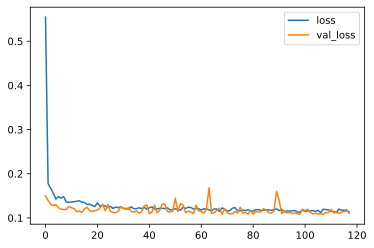

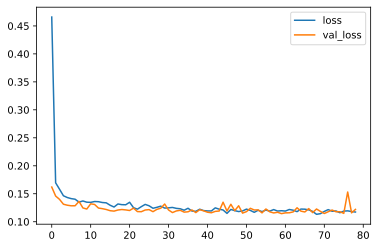

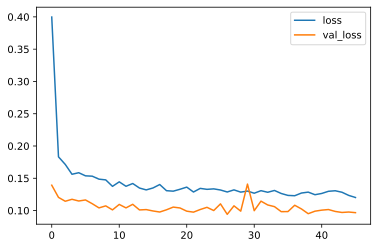

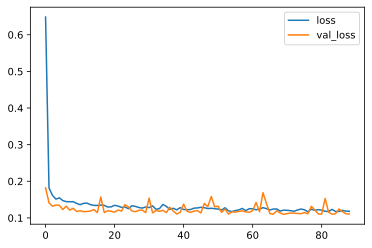

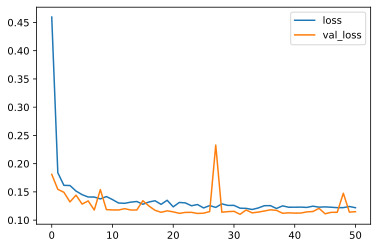

In [8]:
history['fold0'][['loss','val_loss']][:epoch['fold0']].plot()
history['fold1'][['loss','val_loss']][:epoch['fold1']].plot()
history['fold2'][['loss','val_loss']][:epoch['fold2']].plot()
history['fold3'][['loss','val_loss']][:epoch['fold3']].plot()
history['fold4'][['loss','val_loss']][:epoch['fold4']].plot()

### 从 k 个网络中选择若干个预测，保存网络与预测结果

In [11]:
with torch.no_grad():
    Net['fold0'].eval()
    Y_hat = Net['fold0'](X_test)
    Y_hat_numpy = Y_hat.numpy()
    print(Y_hat_numpy)
    
    for i in range(1,5):
        if i != 3:
            Net['fold'+str(i)].eval()
            Y_hat_2 = Net['fold'+str(i)](X_test)
            print(Y_hat_2.numpy())
            Y_hat_numpy += Y_hat_2.numpy()
    Y_hat_numpy /= 4.0
    print(Y_hat_numpy)
    
    
np.savetxt('predictions.txt', Y_hat_numpy)


[[ 0.26419452]
 [ 0.18125162]
 [-0.02535975]
 ...
 [-2.7675471 ]
 [-2.7837803 ]
 [-2.6135085 ]]
[[ 0.30762374]
 [ 0.2286602 ]
 [-0.01876959]
 ...
 [-2.7106822 ]
 [-2.7729635 ]
 [-2.5572808 ]]
[[ 0.30091614]
 [ 0.24703178]
 [-0.03284861]
 ...
 [-3.0072496 ]
 [-3.0206296 ]
 [-2.785062  ]]
[[ 0.29091147]
 [ 0.21898119]
 [-0.02565932]
 ...
 [-2.828493  ]
 [-2.8591244 ]
 [-2.6519506 ]]


In [13]:
torch.save(Net['fold0'], '\model0.pkl')
#torch.save(Net['fold1'], '\model1.pkl')
torch.save(Net['fold2'], '\model2.pkl')
#torch.save(Net['fold3'], '\model3.pkl')
torch.save(Net['fold4'], '\model4.pkl')

### 可以对多种结构的网络结果取平均

In [28]:
#
Y_1 = pd.read_csv('0.119 predictions-(100_40_10)-(3,3,5)_18_earlydrop_5fold_noNorm.txt' , names=['0.119'])
Y_2 = pd.read_csv('0.117/predictions-(100_50_10)-(3,3,5)_18_earlystop_5fold_noNorm.txt' , names=['0.117'])
Y_3 = pd.read_csv('0.1189/predictions-(100_50_12)-(3,3,5)_18_earlystop_5fold_noNorm.txt' , names=['0.118'])
Y = (np.array(Y_1)*3.0 + np.array(Y_2) + np.array(Y_3)) / 5.0
np.savetxt('predictions-117-118-119.txt', Y_hat_numpy)
Y

array([[ 0.31117039],
       [ 0.244168  ],
       [-0.03066494],
       ...,
       [-2.75928302],
       [-2.77529812],
       [-2.59664202]])